In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg,to_date, datediff,year
import hashlib
from pyspark.sql.functions import udf,unix_timestamp

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

from pyspark.sql.types import *
from pyspark.sql import Row

from pyspark.ml.feature import StringIndexer

In [2]:
conf = SparkConf().setAppName("test").setMaster("*")
spark = SparkSession.builder.getOrCreate()

In [3]:
def fix_ids(s):
    return int(int(hashlib.sha1(s).hexdigest(), 16) % 15487469)

fix_ids_udf = udf(fix_ids)

def fix_decimal_values(s):
    return float(round(s,2))

fix_round_udf = udf(fix_decimal_values)

def conv_to_int(v):
    return int(v)

to_int_udf = udf(conv_to_int)

In [4]:
import platform

print(platform.python_version())

2.7.12


## Review Data Loaded

In [5]:
df = spark.read.json('data/dataset/review.json')
rating_df = df.select(df['user_id'],df['stars'].cast('int'),df['business_id'],df['date'].cast('date') )

In [6]:
# user_indexer = StringIndexer(inputCol="user_id", outputCol="userId")
# user_indexed = user_indexer.fit(rating_df).transform(rating_df)
# rating_df = user_indexed.withColumn('userId',to_int_udf(user_indexed['userId']))
# rating_df.show()

In [7]:
# item_indexer = StringIndexer(inputCol="business_id", outputCol="businessId")
# item_indexed = item_indexer.fit(rating_df).transform(rating_df)
# rating_df = item_indexed.withColumn('businessId',to_int_udf(col('businessId')))
# rating_df.show()

In [8]:
rating_df= rating_df.withColumn('userId',fix_ids_udf(rating_df['user_id']).cast('int'))
rating_df= rating_df.withColumn('businessId',fix_ids_udf(rating_df['business_id']).cast('int'))

## User Data Analysis

In [9]:
users = spark.read.json('data/dataset/user.json')

In [10]:
users_selected = users.select(users['user_id'],users['review_count'],users['average_stars'],users['yelping_since'],users['friends'])

In [11]:
users_selected = users_selected.withColumn('user_id',fix_ids_udf(users['user_id']).cast('int'))

In [12]:
users_selected = users_selected.withColumn('yelping_since',users['yelping_since'].cast('date'))

In [13]:
def fix_friends_ids(lst):
    a = []
    for i in lst:
        a.append(fix_ids(i))
    return a

conv_friends_id = udf(fix_friends_ids)

users_selected = users_selected.withColumn('friends',conv_friends_id(users_selected['friends']))

In [14]:
users_selected.show(10)

+--------+------------+-------------+-------------+--------------------+
| user_id|review_count|average_stars|yelping_since|             friends|
+--------+------------+-------------+-------------+--------------------+
| 8436418|           8|         4.67|   2014-11-03|[6446606, 5351372...|
| 3894741|          10|          3.7|   2013-09-24|[8017723, 1353619...|
| 4586614|           1|          2.0|   2017-03-02|                  []|
| 2754013|           6|         4.67|   2015-03-13|                  []|
| 2057328|           3|         4.67|   2016-09-08|                  []|
|10490533|          11|         3.45|   2012-07-16|                  []|
| 8197779|           9|         4.78|   2012-05-01|                  []|
|13063445|           2|          5.0|   2013-03-23|                  []|
|13414689|           1|          1.0|   2010-10-10|                  []|
|10013351|           7|         4.29|   2012-10-16|                  []|
+--------+------------+-------------+-------------+

In [15]:
user_review_yelping_since = users_selected.groupBy(users_selected['yelping_since']).agg(avg(col('average_stars'))).sort(col('yelping_since').desc())

In [16]:
pdf = user_review_yelping_since.toPandas()
pdf.head(10)

,yelping_since,avg(average_stars)
0,2017-12-11,3.407615
1,2017-12-10,3.611700
2,2017-12-09,3.711601
3,2017-12-08,3.716089
4,2017-12-07,3.724940
5,2017-12-06,3.791422
6,2017-12-05,3.731330
7,2017-12-04,3.621106
8,2017-12-03,3.430347
9,2017-12-02,3.411208


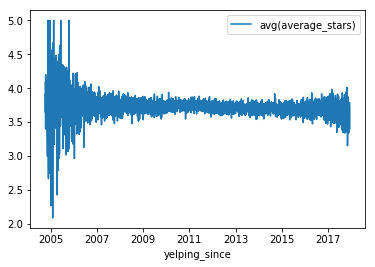

In [17]:
pdf.plot(x='yelping_since',y='avg(average_stars)')

In [18]:
user_review_review_count = users_selected.groupBy(users_selected['review_count']).agg(avg(col('average_stars'))).sort(col('review_count').desc())

In [19]:
pdf_review_count = user_review_review_count.toPandas()
pdf_review_count.head(10)

,review_count,avg(average_stars)
0,11954,3.28
1,11323,3.82
2,9788,3.80
3,8353,3.58
4,7764,3.49
5,6653,3.32
6,6314,3.69
7,5868,3.29
8,5344,3.93
9,4634,3.80


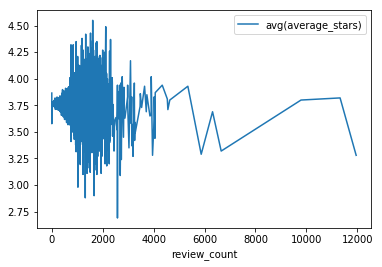

In [20]:
pdf_review_count.plot(x='review_count',y='avg(average_stars)')

In [21]:
user_review_dict = dict(users_selected.select(col('user_id'),col('average_stars')).rdd.map(lambda x: (x.user_id,x.average_stars)).collect())
#print(user_review_dict[5807338])
#print(user_review_dict[853204])

In [22]:
def friends_avg(x):
    sm = 0
    p = 0
    for i in x:
        if i in user_review_dict:
            sm = sm + user_review_dict[i]
            p = p + 1
    if p > 0:        
        return round(sm/p,2)

get_friends_avg = udf(friends_avg)

users_friends = users_selected.withColumn('friends_avg',get_friends_avg(users_selected['friends']))

In [23]:
users_friends.filter(users_friends['friends_avg'].isNotNull()).show(10)

+--------+------------+-------------+-------------+--------------------+-----------+
| user_id|review_count|average_stars|yelping_since|             friends|friends_avg|
+--------+------------+-------------+-------------+--------------------+-----------+
| 8436418|           8|         4.67|   2014-11-03|[6446606, 5351372...|       4.39|
| 3894741|          10|          3.7|   2013-09-24|[8017723, 1353619...|       3.83|
| 6228320|           3|         3.33|   2017-01-07|[6924609, 2017178...|       3.43|
|12386847|          48|         3.73|   2010-07-06|[14021683, 104318...|       4.01|
| 7138897|          50|         3.96|   2007-08-22|[10225511, 994544...|       3.93|
|11774897|         762|          3.6|   2008-09-23|[3571911, 1620957...|        3.8|
|12432335|          31|         3.76|   2013-06-03|[7330490, 2040800...|       4.17|
| 1362809|           2|          5.0|   2013-02-13|[14093868, 124512...|       3.93|
|  474716|          37|         3.97|   2010-05-02|[8207499, 5863

In [24]:
pdf_friends_avg = users_friends.filter(users_friends['friends_avg'].isNotNull()).filter(users_friends['user_id']<10000).select(col('average_stars'),col('friends_avg')).toPandas()
pdf_friends_avg.head(10)

,average_stars,friends_avg
0,3.92,3.79
1,1.00,3.76
2,4.68,3.55
3,3.71,3.46
4,3.50,3.63
5,4.58,4.34
6,3.86,2.97
7,3.57,3.34
8,3.72,4.71
9,5.00,4.19


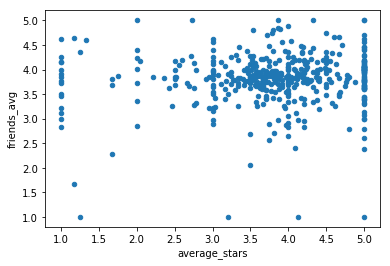

In [25]:
pdf_friends_avg = pdf_friends_avg.astype(float)
#plt.rcParams['agg.path.chunksize'] = 1000
pdf_friends_avg.plot.scatter(x='average_stars',y='friends_avg')

## Restaurent Data Analysis

In [26]:
business_df = spark.read.json('data/dataset/business.json')

In [27]:
business_category_select = business_df.select(col('business_id'),col('categories'))

In [28]:
business_category = business_category_select.withColumn('business_id',fix_ids_udf(business_category_select['business_id']).cast('int')).select(col('business_id'),col('categories'))

In [29]:
business_category.show(10)

+-----------+--------------------+
|business_id|          categories|
+-----------+--------------------+
|    2718457|[Dentists, Genera...|
|   11286356|[Hair Stylists, H...|
|    1442508|[Departments of M...|
|   14681532|[Sporting Goods, ...|
|    4211146|[American (New), ...|
|    7100726|[Italian, Restaur...|
|    5813012|[Real Estate Serv...|
|    1525688|[Shopping, Sporti...|
|   12525828|[Coffee & Tea, Ic...|
|    1098354|[Automotive, Auto...|
+-----------+--------------------+
only showing top 10 rows



In [30]:
schema = StructType([StructField('business_id',IntegerType()), StructField('category',StringType())])
business_category_separated = spark.createDataFrame(spark.sparkContext.parallelize(business_category.rdd.map(lambda x: [(x.business_id,i) for i in x.categories]).reduce(lambda x,y:x+y)),schema)

In [31]:
business_category_separated.show(10)

+-----------+--------------------+
|business_id|            category|
+-----------+--------------------+
|    2718457|            Dentists|
|    2718457|   General Dentistry|
|    2718457|    Health & Medical|
|    2718457|       Oral Surgeons|
|    2718457|   Cosmetic Dentists|
|    2718457|       Orthodontists|
|   11286356|       Hair Stylists|
|   11286356|         Hair Salons|
|   11286356|   Men's Hair Salons|
|   11286356|Blow Dry/Out Serv...|
+-----------+--------------------+
only showing top 10 rows



In [32]:
business_category_separated.groupBy(col('category')).agg({'business_id':'count'}).show(50)

+--------------------+------------------+
|            category|count(business_id)|
+--------------------+------------------+
|      Dermatologists|               255|
|    Historical Tours|                38|
|      Paddleboarding|                36|
| Mobile Home Dealers|                 3|
|    Hot Air Balloons|                16|
|       Videographers|               142|
|       Data Recovery|               137|
|         Boat Repair|                68|
|       Skating Rinks|                78|
|              Fondue|                45|
|             Beaches|                52|
|     Pet Photography|                30|
|        Contract Law|                 8|
|        Aerial Tours|                10|
|   Signature Cuisine|                 1|
|            Day Spas|              2274|
|         Hobby Shops|               683|
|               Reiki|               216|
| Private Jet Charter|                 6|
|      Serbo Croatian|                16|
|            Honduran|            

In [33]:
user_business_category = rating_df.join(business_category_separated,rating_df.businessId==business_category_separated.business_id).select(col('userId'),col('businessId'),col('date'),col('stars'),col('category'))

In [34]:
user_business_category.show(10)

+--------+----------+----------+-----+-----------+
|  userId|businessId|      date|stars|   category|
+--------+----------+----------+-----+-----------+
|15406672|      1088|2008-04-09|    5| Mass Media|
|15406672|      1088|2008-04-09|    5|Print Media|
| 3472140|      1088|2008-02-02|    1| Mass Media|
| 3472140|      1088|2008-02-02|    1|Print Media|
| 9722800|      1088|2007-10-30|    2| Mass Media|
| 9722800|      1088|2007-10-30|    2|Print Media|
| 6968160|      1088|2008-02-13|    2| Mass Media|
| 6968160|      1088|2008-02-13|    2|Print Media|
|12597094|      1088|2008-02-01|    5| Mass Media|
|12597094|      1088|2008-02-01|    5|Print Media|
+--------+----------+----------+-----+-----------+
only showing top 10 rows



In [35]:
user_business_category.groupBy(col('category')).count().toPandas().head(50)

,category,count
0,Dermatologists,4231
1,Historical Tours,729
2,Paddleboarding,558
3,Hot Air Balloons,554
4,Mobile Home Dealers,10
5,Skating Rinks,1336
6,Pet Photography,190
7,Videographers,1241
8,Boat Repair,586
9,Data Recovery,2849


In [36]:
category_density = user_business_category.groupBy(col('category')).agg(avg(col('stars')).cast('float').alias('avg_stars')).toPandas()

In [37]:
category_density.head(10)

,category,avg_stars
0,Dermatologists,3.393760
1,Historical Tours,4.584362
2,Paddleboarding,4.648746
3,Hot Air Balloons,4.720217
4,Mobile Home Dealers,3.000000
5,Skating Rinks,3.512725
6,Pet Photography,4.873684
7,Videographers,4.478646
8,Boat Repair,4.179181
9,Data Recovery,4.443665


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


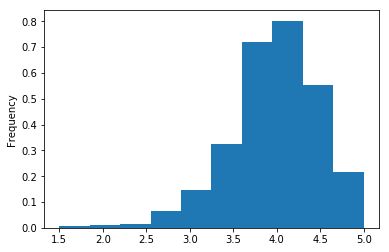

In [38]:
category_density['avg_stars'].plot(kind='hist', normed=True)
range = np.arange(1.5, 5, 0.001)
avg = 3.7
#plt.plot(range, norm.pdf(range,avg,.5))

## Recommendation

In [39]:
gavg=user_business_category.groupBy().agg({"stars": "avg"}).collect()[0][0]
print(gavg)
#gavg = 3.7266

3.76095445756


In [40]:
df_user_avg = user_business_category.groupby(col('userId')).agg({'stars':'avg'}).select('userId',col('avg(stars)').alias('user-mean').cast('float'))
df_user_avg2 = user_business_category.join(df_user_avg,'userId')
user_data = df_user_avg2.withColumn('user-mean',fix_round_udf(df_user_avg2['user-mean']))
user_data.show(5)

+------+----------+----------+-----+--------------------+---------+
|userId|businessId|      date|stars|            category|user-mean|
+------+----------+----------+-----+--------------------+---------+
|   496|   2364615|2017-10-31|    3|Event Planning & ...|     3.14|
|   496|   2364615|2017-10-31|    3|         Restaurants|     3.14|
|   496|   2364615|2017-10-31|    3|            Caterers|     3.14|
|   496|   2364615|2017-10-31|    3|American (Traditi...|     3.14|
|   496|   2364615|2017-10-31|    3|        Comfort Food|     3.14|
+------+----------+----------+-----+--------------------+---------+
only showing top 5 rows



In [41]:
df_item_avg = user_business_category.groupby(col('businessId')).agg({'stars':'avg'}).select('businessId',col('avg(stars)').alias('item-mean').cast('float'))
df_item_avg2 = user_data.join(df_item_avg,'businessId')
item_data = df_item_avg2.withColumn('item-mean',fix_round_udf(df_item_avg2['item-mean']))
item_data.show(5)

+----------+--------+----------+-----+-----------+---------+---------+
|businessId|  userId|      date|stars|   category|user-mean|item-mean|
+----------+--------+----------+-----+-----------+---------+---------+
|      1088| 3915923|2007-07-27|    3| Mass Media|     3.94|      2.8|
|      1088| 3915923|2007-07-27|    3|Print Media|     3.94|      2.8|
|      1088|  331248|2007-05-25|    4| Mass Media|     4.01|      2.8|
|      1088|  331248|2007-05-25|    4|Print Media|     4.01|      2.8|
|      1088|12597094|2008-02-01|    5| Mass Media|     3.02|      2.8|
+----------+--------+----------+-----+-----------+---------+---------+
only showing top 5 rows



In [42]:
df_category_avg = user_business_category.groupby(col('category')).agg({'stars':'avg'}).select('category',col('avg(stars)').alias('category-mean').cast('float'))
df_category_avg2 = item_data.join(df_category_avg,'category')
category_data = df_category_avg2.withColumn('category-mean',fix_round_udf(df_category_avg2['category-mean']))
category_data.show(5)

+--------------+----------+--------+----------+-----+---------+---------+-------------+
|      category|businessId|  userId|      date|stars|user-mean|item-mean|category-mean|
+--------------+----------+--------+----------+-----+---------+---------+-------------+
|Dermatologists|   7344456|13271053|2011-03-23|    2|     3.22|     3.25|         3.39|
|Dermatologists|   7344456|  946885|2014-06-04|    1|     2.47|     3.25|         3.39|
|Dermatologists|   7344456| 7422512|2016-07-06|    5|      5.0|     3.25|         3.39|
|Dermatologists|   7344456|  613097|2016-07-07|    5|      5.0|     3.25|         3.39|
|Dermatologists|   1293808|13507985|2016-07-23|    1|     2.23|     3.27|         3.39|
+--------------+----------+--------+----------+-----+---------+---------+-------------+
only showing top 5 rows



In [43]:
data_filtered = category_data.withColumn('user-item-interaction',category_data.stars-(category_data['user-mean']+\
    category_data['item-mean']-gavg))
final_data = data_filtered.withColumn('user-item-interaction',fix_round_udf(data_filtered['user-item-interaction']))
final_data.show(5)

+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+
|      category|businessId|  userId|      date|stars|user-mean|item-mean|category-mean|user-item-interaction|
+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+
|Dermatologists|   7344456|13271053|2011-03-23|    2|     3.22|     3.25|         3.39|                -0.71|
|Dermatologists|   7344456|  946885|2014-06-04|    1|     2.47|     3.25|         3.39|                -0.96|
|Dermatologists|   7344456| 7422512|2016-07-06|    5|      5.0|     3.25|         3.39|                 0.51|
|Dermatologists|   7344456|  613097|2016-07-07|    5|      5.0|     3.25|         3.39|                 0.51|
|Dermatologists|   1293808|13507985|2016-07-23|    1|     2.23|     3.27|         3.39|                -0.74|
+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+
only showi

In [44]:
seed_data = final_data.select('userId','businessId',col('user-item-interaction').cast('float'))
seed_data.show(5)

+--------+----------+---------------------+
|  userId|businessId|user-item-interaction|
+--------+----------+---------------------+
|13271053|   7344456|                -0.71|
|  946885|   7344456|                -0.96|
| 7422512|   7344456|                 0.51|
|  613097|   7344456|                 0.51|
|13507985|   1293808|                -0.74|
+--------+----------+---------------------+
only showing top 5 rows



In [45]:
(training,test,spill) = seed_data.randomSplit([0.18,0.02,.80],123)

In [46]:
training.show(5)

+------+----------+---------------------+
|userId|businessId|user-item-interaction|
+------+----------+---------------------+
| 15260|  12929346|                -0.02|
| 17040|  13400651|                -0.03|
| 26414|  12198385|                -1.23|
| 43237|  12277671|                 0.94|
| 94468|   4241012|                -0.57|
+------+----------+---------------------+
only showing top 5 rows



In [47]:
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="businessId", ratingCol='user-item-interaction',
          coldStartStrategy="drop",rank=40)
model = als.fit(training)

In [48]:
predictions = model.transform(test)
predictions.show(5)

+-------+----------+---------------------+-----------+
| userId|businessId|user-item-interaction| prediction|
+-------+----------+---------------------+-----------+
|2539263|     15447|                -1.18| -1.1711619|
|5955479|     37489|                 0.53| 0.14480537|
|2167328|     37489|                 0.71|-0.30136073|
|3003050|     46266|                 1.02|  0.8504933|
|6506370|     46266|                 1.61|  1.0505974|
+-------+----------+---------------------+-----------+
only showing top 5 rows



In [49]:
predictions2 = predictions.withColumn('prediction',fix_round_udf(predictions['prediction']))
predictions3 = predictions2.select('userId','businessId',col('user-item-interaction').cast('float'),col('prediction').cast('float'))
predictions3.show(5)

+-------+----------+---------------------+----------+
| userId|businessId|user-item-interaction|prediction|
+-------+----------+---------------------+----------+
|2539263|     15447|                -1.18|     -1.17|
|5955479|     37489|                 0.53|      0.14|
|2167328|     37489|                 0.71|      -0.3|
|3003050|     46266|                 1.02|      0.85|
|6506370|     46266|                 1.61|      1.05|
+-------+----------+---------------------+----------+
only showing top 5 rows



In [50]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="user-item-interaction",predictionCol="prediction")
rmse = evaluator.evaluate(predictions3)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.788095778623


### After 2007

In [51]:
seed_data2 = final_data.withColumn('date',to_date(col('date')))
seed_data2.show(5)

+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+
|      category|businessId|  userId|      date|stars|user-mean|item-mean|category-mean|user-item-interaction|
+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+
|Dermatologists|   7344456|13271053|2011-03-23|    2|     3.22|     3.25|         3.39|                -0.71|
|Dermatologists|   7344456|  946885|2014-06-04|    1|     2.47|     3.25|         3.39|                -0.96|
|Dermatologists|   7344456| 7422512|2016-07-06|    5|      5.0|     3.25|         3.39|                 0.51|
|Dermatologists|   7344456|  613097|2016-07-07|    5|      5.0|     3.25|         3.39|                 0.51|
|Dermatologists|   1293808| 5253906|2016-11-17|    1|     4.29|     3.27|         3.39|                 -2.8|
+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+
only showi

In [52]:
def get_2007s(x):
    return '2007-12-31'

get_2007_udf = udf(get_2007s)

seed_data3 = seed_data2.withColumn('in2007',get_2007_udf(col('date'))  )
seed_data3.show(5)

+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+----------+
|      category|businessId|  userId|      date|stars|user-mean|item-mean|category-mean|user-item-interaction|    in2007|
+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+----------+
|Dermatologists|   7344456|13271053|2011-03-23|    2|     3.22|     3.25|         3.39|                -0.71|2007-12-31|
|Dermatologists|   7344456|  946885|2014-06-04|    1|     2.47|     3.25|         3.39|                -0.96|2007-12-31|
|Dermatologists|   7344456| 7422512|2016-07-06|    5|      5.0|     3.25|         3.39|                 0.51|2007-12-31|
|Dermatologists|   7344456|  613097|2016-07-07|    5|      5.0|     3.25|         3.39|                 0.51|2007-12-31|
|Dermatologists|   1293808| 5253906|2016-11-17|    1|     4.29|     3.27|         3.39|                 -2.8|2007-12-31|
+--------------+----------+-----

In [53]:
seed_data4 = seed_data3.filter(datediff(seed_data3.date, seed_data3.in2007) > 0 )
seed_data4.show(5)

+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+----------+
|      category|businessId|  userId|      date|stars|user-mean|item-mean|category-mean|user-item-interaction|    in2007|
+--------------+----------+--------+----------+-----+---------+---------+-------------+---------------------+----------+
|Dermatologists|   7344456|13271053|2011-03-23|    2|     3.22|     3.25|         3.39|                -0.71|2007-12-31|
|Dermatologists|   7344456|  946885|2014-06-04|    1|     2.47|     3.25|         3.39|                -0.96|2007-12-31|
|Dermatologists|   7344456| 7422512|2016-07-06|    5|      5.0|     3.25|         3.39|                 0.51|2007-12-31|
|Dermatologists|   7344456|  613097|2016-07-07|    5|      5.0|     3.25|         3.39|                 0.51|2007-12-31|
|Dermatologists|   1293808| 5253906|2016-11-17|    1|     4.29|     3.27|         3.39|                 -2.8|2007-12-31|
+--------------+----------+-----

In [54]:
seed_data4.filter(datediff(seed_data4.date, seed_data3.in2007) < 0 ).show()

+--------+----------+------+----+-----+---------+---------+-------------+---------------------+------+
|category|businessId|userId|date|stars|user-mean|item-mean|category-mean|user-item-interaction|in2007|
+--------+----------+------+----+-----+---------+---------+-------------+---------------------+------+
+--------+----------+------+----+-----+---------+---------+-------------+---------------------+------+



In [55]:
seed_data5 = seed_data4.select('userId','businessId',col('user-item-interaction').cast('float'))
(training2,test2,spill) = seed_data5.randomSplit([0.18,0.02,.80],123)

In [56]:
training2.show(5)

+------+----------+---------------------+
|userId|businessId|user-item-interaction|
+------+----------+---------------------+
| 15260|  12929346|                -0.02|
| 17040|  13400651|                -0.03|
| 26414|  12198385|                -1.23|
| 43237|  12277671|                 0.94|
| 94468|   4241012|                -0.57|
+------+----------+---------------------+
only showing top 5 rows



In [57]:
als2 = ALS(maxIter=10, regParam=0.01, userCol="userId", itemCol="businessId", ratingCol='user-item-interaction',
          coldStartStrategy="drop",rank=40)
model_dated = als2.fit(training2)

In [58]:
predictions_dated = model_dated.transform(test2)

In [59]:
predictions_dated2 = predictions_dated.withColumn('prediction',fix_round_udf(predictions_dated['prediction']))
predictions_dated3 = predictions_dated2.select('userId','businessId',col('user-item-interaction').cast('float'),col('prediction').cast('float'))

In [60]:
rmse_dated = evaluator.evaluate(predictions_dated3)
print("Root-mean-square error = " + str(rmse_dated))

Root-mean-square error = 0.771059836805
